# Business Cycle Facts and Real Business Cycles Model

We will take a look at the data on business cycle fluctuations in the United States and then see if we can explain their behavior with the help of the basic RBC model.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas_datareader.data import DataReader

In [2]:
from matplotlib import rcParams

# Restore old behavior of rounding default axis ranges
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0

# Adjust tick placement
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

# Disable legend frame
rcParams['legend.frameon'] = False

Below we are downloading data from Federal Reserve Bank of St. Louis Economic Database (FRED) https://fred.stlouisfed.org/ and organizing them into three datasets.

The first dataset, `rec`, contains monthly data on whether in a given month the US economy was in a recession state (`1`) or not (`0`) - `USREC`

The second dataset, `pop`, containts quarterly data on:
- total population in the US - `B230RC0Q173SBEA`
- civilian noninstitutional population of 16 years of age and older - `CNP16OV`

The third dataset, `fred`, contains quarterly data on:

- nominal Gross Domestic Product in billions of current dollars - `GDP`
- nominal Personal Consumption Expenditures on Nondurable Goods - `PCND`
- nominal Personal Consumption Expenditures on Services - `PCESV`
- nominal Personal Consumption Expenditures on Durable Goods - `PCDG`
- nominal Fixed Private Investment - `FPI`
- Implicit Price Deflator for Gross Domestic Product - `GDPDEF`
- Nonfarm Business Sector: Current Dollar Output - `PRS85006053`
- total hours worked in the nonfarm business sector (index) - `HOANBS`
- nominal compensation per hour in the nonfarm business sector (index) - `COMPNFB`
- interest rate on 3-month treasury bill - `TB3MS`

In [3]:
start = '1945-01'
end   = '2030-01'

In [4]:
rec = DataReader('USREC', 'fred', start=start, end=end)
rec = rec.dropna()

pop = DataReader(['B230RC0Q173SBEA', 'CNP16OV'], 'fred', start=start, end=end)
pop = pop.dropna()
pop = pop.resample('QS').mean()
pop = pop.dropna()

pop.tail()

,B230RC0Q173SBEA,CNP16OV
DATE,,
2018-07-01,327697.0,257843.0
2018-10-01,328237.0,258514.0
2019-01-01,328678.0,258239.0
2019-04-01,329135.0,258693.0
2019-07-01,329689.0,259225.0


In [5]:
fred = DataReader(['GDP', 'PCND', 'PCESV', 'PCDG', 'FPI', 'GDPDEF',
                   'PRS85006053', 'HOANBS', 'COMPNFB', 'TB3MS'],
                  'fred', start=start, end=end)
fred = fred.dropna()
fred = fred.resample('QS').mean()
fred = fred.dropna()
fred.head()

,GDP,PCND,PCESV,PCDG,FPI,GDPDEF,PRS85006053,HOANBS,COMPNFB,TB3MS
DATE,,,,,,,,,,
1947-01-01,243.164,74.872,60.567,20.722,35.359,11.960,1.477,46.322,3.709,0.38
1947-04-01,245.968,76.897,61.783,21.351,35.744,12.131,1.532,46.334,3.793,0.38
1947-07-01,249.585,78.649,63.124,21.770,37.827,12.335,1.556,46.456,3.906,0.66
1947-10-01,259.745,79.965,64.219,23.488,41.794,12.639,1.631,46.906,3.999,0.85
1948-01-01,265.742,81.546,65.279,23.547,43.576,12.739,1.678,47.204,4.093,0.97


In [6]:
fred.tail()

,GDP,PCND,PCESV,PCDG,FPI,GDPDEF,PRS85006053,HOANBS,COMPNFB,TB3MS
DATE,,,,,,,,,,
2018-07-01,20749.752,2912.772,9716.554,1485.233,3596.671,110.767,130.390,112.123,116.137,1.96
2018-10-01,20897.804,2913.770,9812.522,1485.629,3625.164,111.256,131.175,112.438,116.351,2.25
2019-01-01,21098.827,2912.327,9868.573,1485.350,3670.075,111.473,132.442,112.559,118.991,2.37
2019-04-01,21340.267,2982.376,10004.183,1524.617,3674.673,112.188,134.079,112.406,120.443,2.38
2019-07-01,21542.104,3010.083,10109.118,1550.441,3675.700,112.656,135.168,113.079,121.414,2.10


Since the population data are based on the population census, they exhibit periodic "jumps" that we will filter out

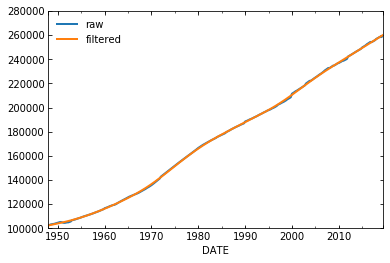

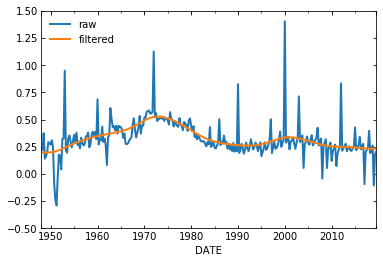

In [7]:
pop_hp_cycle, pop_hp_trend = sm.tsa.filters.hpfilter(np.log(pop), lamb=10000)
pop_smooth = np.exp(pop_hp_trend)

fig, ax = plt.subplots()

pop['CNP16OV'].to_period('D').plot(ax=ax, lw=2)
pop_smooth['CNP16OV'].to_period('D').plot(ax=ax, lw=2)
plt.legend(['raw', 'filtered'])
plt.show()

fig, ax = plt.subplots()

(100*pop['CNP16OV'].pct_change()).to_period('D').plot(ax=ax, lw=2)
(100*pop_smooth['CNP16OV'].pct_change()).to_period('D').plot(ax=ax, lw=2)
plt.legend(['raw', 'filtered'], loc='upper left')
plt.show()

Below we are constructing the series that will correspond to model objects. All variables will be expressed in logarithms:
- `Output` is real GDP per person (aged 16 and over)
- `Consumption` is the real sum of expenditures on nondurable goods and services per person
- `Investment` is the real sum of expenditures on durable goods and fixed private investment per person
- `Capital` will contain real capital stock per person (to be constructed later)
- `Hours` is hours worked per person, corrected for the difference between the entire economy and the nonfarm business sector
- `Wages` is real compensation per hour worked
- `Interest Rate` is the real quarterly return on the 3 month treasury bill
- `TFP` will contain Total Factor Productivity series (to be constructed later)
- `Productivity` is the real output per hour worked in the nonfarm business sector
- `Price Level` is the GDP implicit price deflator

In [8]:
dta = fred[['GDP']]
dta.is_copy = False

dta['Output'] = np.log(fred['GDP']*10**9/fred['GDPDEF']*100
                       /(pop_smooth['CNP16OV']*10**3))

dta['Consumption'] = np.log((fred['PCND']+fred['PCESV'])*10**9/fred['GDPDEF']*100
                            /(pop_smooth['CNP16OV']*10**3))

dta['Investment'] = np.log((fred['PCDG']+fred['FPI'])*10**9/fred['GDPDEF']*100
                           /(pop_smooth['CNP16OV']*10**3))

dta['Capital'] = 0*dta['Output']

dta['Hours'] = np.log(fred['HOANBS']*100*fred['GDP']/np.mean(fred['GDP']['2010-01':'2010-10'])
                      /fred['PRS85006053']/pop_smooth['CNP16OV'])

dta['Wages'] = np.log(fred['COMPNFB']/fred['GDPDEF']*100)

dta['Interest Rate'] = np.log( (1+fred['TB3MS']/100)**(1/4)/(1+fred['GDPDEF'].pct_change()) )

dta['TFP'] = 0*dta['Output']

dta['Productivity'] = np.log(fred['PRS85006053']/fred['GDPDEF']*100)-dta['Hours']

dta['Price Level'] = np.log(fred['GDPDEF'])

dta = dta.drop('GDP', 1)
dta = dta.dropna()

dta.head()

C:\Users\u157044\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\u157044\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


,Output,Consumption,Investment,Capital,Hours,Wages,Interest Rate,TFP,Productivity,Price Level
DATE,,,,,,,,,,
1948-01-01,9.922162,9.328878,8.546163,0.0,-7.627080,3.469780,-0.005468,0.0,10.205184,2.544668
1948-04-01,9.936567,9.340138,8.555458,0.0,-7.617116,3.474141,-0.006499,0.0,10.199259,2.553655
1948-07-01,9.940283,9.330900,8.565994,0.0,-7.615886,3.476316,-0.015859,0.0,10.207527,2.572001
1948-10-01,9.939447,9.333508,8.556237,0.0,-7.631541,3.482902,-0.000266,0.0,10.228676,2.575052
1949-01-01,9.923621,9.333202,8.514221,0.0,-7.656080,3.494543,0.008253,0.0,10.244853,2.569707


In [9]:
dta.tail()

,Output,Consumption,Investment,Capital,Hours,Wages,Interest Rate,TFP,Productivity,Price Level
DATE,,,,,,,,,,
2018-07-01,11.193802,10.697289,9.786954,0.0,-7.680489,4.652512,0.000455,0.0,12.448760,4.707429
2018-10-01,11.194190,10.698216,9.785901,0.0,-7.678892,4.649948,0.001158,0.0,12.448761,4.711834
2019-01-01,11.199501,10.698235,9.790333,0.0,-7.680170,4.670436,0.003907,0.0,12.457703,4.713782
2019-04-01,11.202172,10.705491,9.790098,0.0,-7.684750,4.676171,-0.000513,0.0,12.468173,4.720176
2019-07-01,11.205109,10.709177,9.788773,0.0,-7.679769,4.680037,0.001033,0.0,12.467119,4.724339


Below we will estimate the capital stock based on the Perpetual Inventory Method (PIM) that simply applies the capital accumulation equation:

\begin{align}
K_{t+1} = I_{t} + \left( 1-\delta \right) K_{t}
\end{align}

We need to "start" this procedure from a certain level of initial capital stock, $K_{0}$, which is below calculated basing on the investment trend in the beginning of the sample.

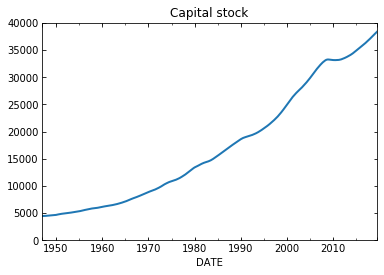

In [10]:
# Estimate Capital series using PIM
temp = fred[['GDP']]
temp.is_copy = False

temp['Inv'] = (fred['PCDG']+fred['FPI'])/fred['GDPDEF']*100/4
temp['LnInv'] = np.log(temp['Inv'])
temp['t'] = np.arange(len(temp['Inv']))

trend = smf.ols(formula='LnInv ~ t', data=temp).fit()
intercept, slope = trend.params

delta = 0.025
K = np.zeros(len(temp['LnInv']))
K_init = np.exp(intercept-slope)/(slope+delta)

K[0] = (1-delta)*K_init+temp['Inv'][0]
for i in range(1,len(temp['Inv'])):
    K[i] = (1-delta)*K[i-1]+temp['Inv'][i]
temp['Cap'] = K

temp['Cap'].to_period('D').plot(lw=2)
plt.title('Capital stock')
plt.show()

# (temp['Cap']/(fred['GDP']/fred['GDPDEF']*100)).to_period('D').plot(lw=2)
# plt.title('$K / Y$')
# plt.show()

We recover the constructed time series for capital and construct the TFP measure from the production function:

\begin{align}
Y_{t} &= K_{t}^{\alpha} \left( A_{t} L_{t} \right)^{1-\alpha} \\
Y_{t} &= TFP_{t} \cdot K_{t}^{\alpha} L_{t}^{1-\alpha} \\
TFP_{t} &= Y_{t} / \left( K_{t}^{\alpha} L_{t}^{1-\alpha} \right) \\
\log TFP_{t} &= \log Y_{t} - \alpha \log K_{t} - \left(1-\alpha \right) \log L_{t}
\end{align}

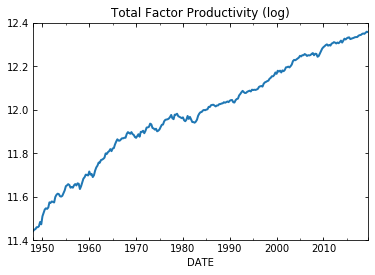

In [11]:
dta['Capital'] = np.log(temp['Cap']*10**9/(pop_smooth['CNP16OV']*10**3))

α = 1/3
dta['TFP'] = dta['Output']-α*dta['Capital']-(1-α)*dta['Hours']
dta['TFP'].to_period('D').plot(lw=2)
plt.title('Total Factor Productivity (log)')
plt.show()

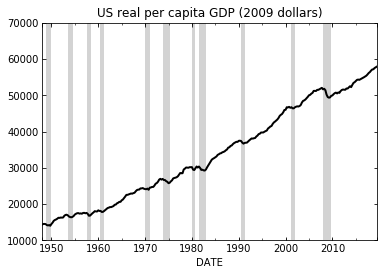

In [12]:
RGDP_pc = (fred['GDP']*10**9/fred['GDPDEF']*100/(pop_smooth['B230RC0Q173SBEA']*10**3)).dropna()

fig, ax = plt.subplots()

RGDP_pc.to_period('D').plot(ax=ax, lw=2, style='k-')

ax.set_ylim(10000, 70000)
ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP (2009 dollars)')
plt.show()

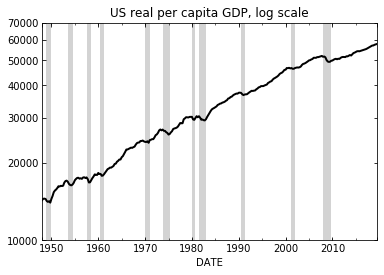

In [13]:
fig, ax = plt.subplots()

np.log(RGDP_pc).to_period('D').plot(ax=ax, lw=2, style='k-')

ticks = [10000, 20000, 30000, 40000, 50000, 60000, 70000]
ax.set_yticks(np.log(ticks))
ax.set_yticklabels(ticks)

ax.set_ylim(np.log(ticks[0]), np.log(ticks[-1]))

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, log scale')
plt.show()

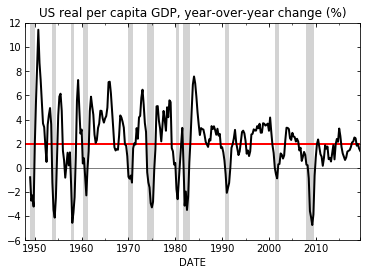

Average growth rate (%) = 2.0036168013273215


In [14]:
fig, ax = plt.subplots()

(100*RGDP_pc.pct_change(4)).to_period('D').plot(ax=ax, lw=2, style='k-')

avg = np.mean(100*RGDP_pc.to_period('D').pct_change(4))

# ax.set_ylim(-6, 12)
ylim = ax.get_ylim()

ax.hlines(avg, dta.index[0], dta.index[-1], color='r', linewidth=2)
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, year-over-year change (%)')
plt.show()

print('Average growth rate (%) =', avg)

In [15]:
gdp_lin_cycle, gdp_lin_trend = sm.tsa.filters.hpfilter(np.log(RGDP_pc), lamb=1e9)
gdp_hp_cycle, gdp_hp_trend = sm.tsa.filters.hpfilter(np.log(RGDP_pc), lamb=1600)
gdp_cf_cycle, gdp_cf_trend = sm.tsa.filters.cffilter(np.log(RGDP_pc), low=6, high=32)

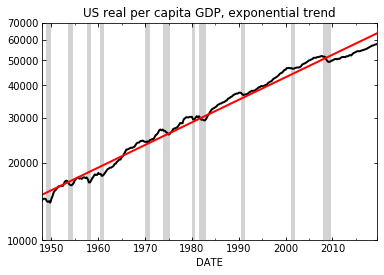

In [16]:
fig, ax = plt.subplots()

np.log(RGDP_pc).to_period('D').plot(ax=ax, lw=2, style='k-')
gdp_lin_trend.plot(ax=ax, lw=2, style='r-')

ticks = [10000, 20000, 30000, 40000, 50000, 60000, 70000]
ax.set_yticks(np.log(ticks))
ax.set_yticklabels(ticks)

ax.set_ylim(np.log(ticks[0]), np.log(ticks[-1]))

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, exponential trend')
plt.show()

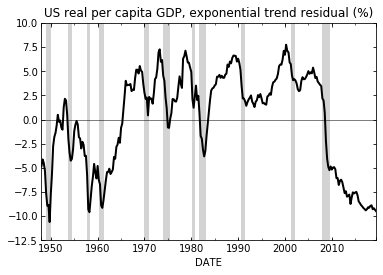

In [17]:
fig, ax = plt.subplots()

(100*gdp_lin_cycle).to_period('D').plot(ax=ax, lw=2, style='k-')
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, exponential trend residual (%)')
plt.show()

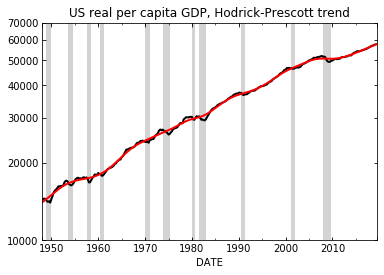

In [18]:
fig, ax = plt.subplots()

np.log(RGDP_pc).to_period('D').plot(ax=ax, lw=2, style='k-')
gdp_hp_trend.plot(ax=ax, lw=2, style='r-')

ticks = [10000, 20000, 30000, 40000, 50000, 60000, 70000]
ax.set_yticks(np.log(ticks))
ax.set_yticklabels(ticks)

ax.set_ylim(np.log(ticks[0]), np.log(ticks[-1]))

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, Hodrick-Prescott trend')
plt.show()

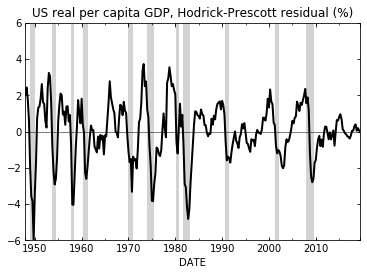

In [19]:
fig, ax = plt.subplots()

(100*gdp_hp_cycle.to_period('D')).plot(ax=ax, lw=2, style='k-')
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ax.set_ylim(-6, 6)
ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, Hodrick-Prescott residual (%)')
plt.show()

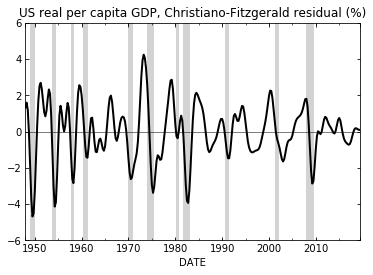

In [20]:
fig, ax = plt.subplots()

(100*gdp_cf_cycle).to_period('D').plot(ax=ax, lw=2, style='k-')
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, Christiano-Fitzgerald residual (%)')
plt.show()

In [21]:
np.corrcoef(gdp_hp_cycle, gdp_cf_cycle)

array([[1.        , 0.88971319],
       [0.88971319, 1.        ]])

In [22]:
hp_cycles, hp_trend = sm.tsa.filters.hpfilter((100*dta).dropna(), lamb=1600)
cf_cycles, cf_trend = sm.tsa.filters.cffilter((100*dta).dropna(), low=6, high=32)

In [23]:
print('Standard Deviations')
print(hp_cycles.std())

print('')
print('Autocorrelations')
a = list(dta.columns.values)
for i in range(len(a)):
    print(dta.columns.values[i], '  \t\t', hp_cycles[dta.columns.values[i]].autocorr())

print('')
print('Correlations')
print(hp_cycles.corr(method='pearson'))

Standard Deviations
Output           1.583536
Consumption      0.837034
Investment       4.480931
Capital          0.561865
Hours            1.595287
Wages            0.823227
Interest Rate    0.386774
TFP              0.984396
Productivity     1.289771
Price Level      0.889009
dtype: float64

Autocorrelations
Output   		 0.8489181324126912
Consumption   		 0.8251642253383615
Investment   		 0.867930160662462
Capital   		 0.9664826982785112
Hours   		 0.9010201175013728
Wages   		 0.6759196832087512
Interest Rate   		 0.41049766770604296
TFP   		 0.699575760211809
Productivity   		 0.6404053281716215
Price Level   		 0.9096604004397023

Correlations
                 Output  Consumption  Investment   Capital     Hours  \
Output         1.000000     0.749030    0.790164  0.366295  0.809091   
Consumption    0.749030     1.000000    0.636950  0.395370  0.676125   
Investment     0.790164     0.636950    1.000000  0.245121  0.638790   
Capital        0.366295     0.395370    0.245121  1.0

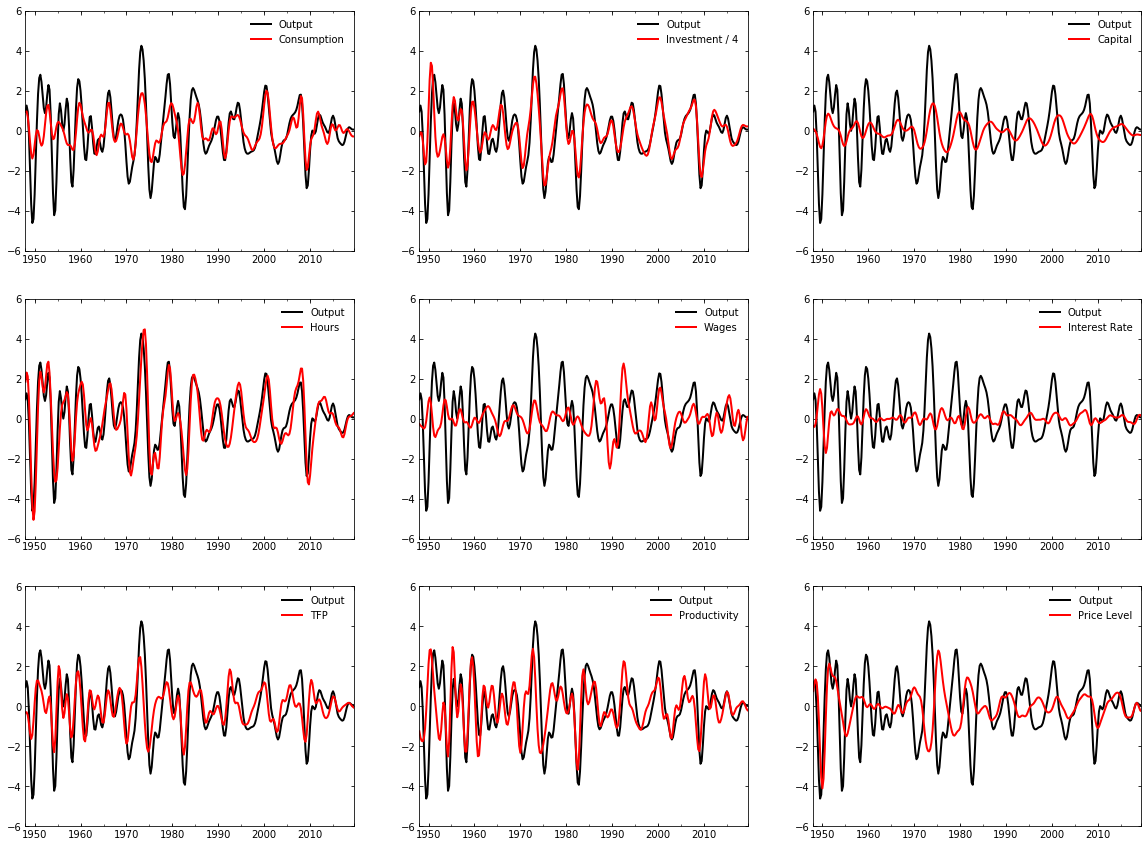

In [24]:
cf_cycles['Investment / 4'] = cf_cycles['Investment'] / 4

fig, axs = plt.subplots(3, 3, figsize=(20, 15), sharex=False, sharey=False)

cf_cycles[['Output','Consumption']].to_period('D').plot(ax=axs[0, 0], style=['k','r'], lw=2)

cf_cycles[['Output','Investment / 4']].to_period('D').plot(ax=axs[0, 1], style=['k','r'], lw=2)

cf_cycles[['Output','Capital']].to_period('D').plot(ax=axs[0, 2], style=['k','r'], lw=2)

cf_cycles[['Output','Hours']].to_period('D').plot(ax=axs[1, 0], style=['k','r'], lw=2)

cf_cycles[['Output','Wages']].to_period('D').plot(ax=axs[1, 1], style=['k','r'], lw=2)

cf_cycles[['Output','Interest Rate']].to_period('D').plot(ax=axs[1, 2], style=['k','r'], lw=2)

cf_cycles[['Output','TFP']].to_period('D').plot(ax=axs[2, 0], style=['k','r'], lw=2)

cf_cycles[['Output','Productivity']].to_period('D').plot(ax=axs[2, 1], style=['k','r'], lw=2)

cf_cycles[['Output','Price Level']].to_period('D').plot(ax=axs[2, 2], style=['k','r'], lw=2)

for ax_a in axs:
    for ax in ax_a:
        ax.set_xlabel('')

# plt.savefig('US_CF.pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)
plt.show()

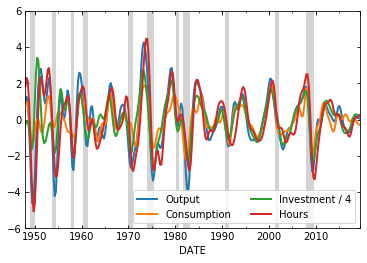

In [25]:
fig, ax = plt.subplots()

cf_cycles[['Output','Consumption','Investment / 4','Hours']].to_period('D').plot(ax=ax, lw=2)

ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.legend(ncol=2, frameon=True)
plt.show()

In [26]:
dta['t'] = np.arange(len(dta['TFP']))
trend_TFP = smf.ols(formula='TFP ~ t', data=dta).fit()
dta['TFP_resid'] = trend_TFP.resid
intercept_TFP, slope_TFP = trend_TFP.params
print(trend_TFP.summary())

                            OLS Regression Results                            
Dep. Variable:                    TFP   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          1.04e-224
Time:                        12:46:18   Log-Likelihood:                 518.59
No. Observations:                 287   AIC:                            -1033.
Df Residuals:                     285   BIC:                            -1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5760      0.005   2466.380      0.0

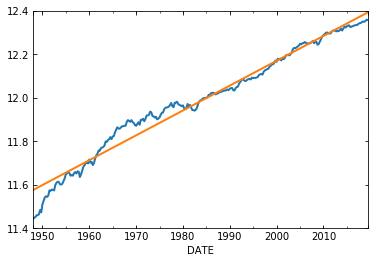

In [27]:
dta['TFP'].to_period('D').plot(lw=2)
(intercept_TFP + slope_TFP*dta['t']).plot(lw=2)
plt.show()

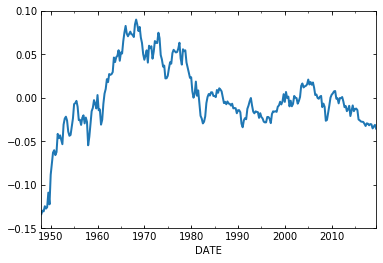

In [28]:
dta['TFP_resid'].to_period('D').plot(lw=2)
plt.show()

In [29]:
resid_TFP = smf.ols(formula='TFP_resid ~ TFP_resid.shift() -1', data=dta).fit()
print(resid_TFP.summary())

print('')
print('TFP residual autocorrelation    =', resid_TFP.params[0])
print('TFP residual standard deviation =', resid_TFP.resid.std())

                            OLS Regression Results                            
Dep. Variable:              TFP_resid   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     6853.
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          2.30e-201
Time:                        12:46:18   Log-Likelihood:                 982.61
No. Observations:                 286   AIC:                            -1963.
Df Residuals:                     285   BIC:                            -1960.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
TFP_resid.shift()     0.9616      0.01

In [30]:
rho_z    = resid_TFP.params[0]
stderr_z = resid_TFP.resid.std()

In [31]:
from Dynare import *

In [32]:
var = 'y c i k h w r z yh R'
varexo = 'e'

param_values = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':1.75, 'sigma':1, 'rho':rho_z}
# param_values = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':1.75, 'sigma':1, 'rho':0.961622403850564}

model = ('-log(z) + rho*log(z(-1)) + e',
         '-k + i + (1-delta)*k(-1)',
         '-c^(-sigma) + betta*c(+1)**(-sigma)*(1+r(+1))',
         '-y + z*k(-1)^alpha*h^(1-alpha)',
         '-r + alpha*y/k(-1) - delta',
         '-w + (1-alpha)*y/h',
         '-phi/(1-h) + w/c',
         '-y + c + i',
         '-yh + y/h',
         '-R + 1+r')

initval = (1, 0.8, 0.2, 10, 0.33, 2, 0.01, 1, 3, 1.01)

In [33]:
rbc = Dynare(var, varexo, param_values, model, initval)

rbc.system

⎡e_{t} + ρ⋅log(z_{t-1}) - log(z_{t})⎤
⎢                                   ⎥
⎢ i_{t} + k_{t-1}⋅(-δ + 1) - k_{t}  ⎥
⎢                                   ⎥
⎢         -σ                      -σ⎥
⎢β⋅c_{t+1}  ⋅(r_{t+1} + 1) - c_{t}  ⎥
⎢                                   ⎥
⎢     -α + 1        α               ⎥
⎢h_{t}      ⋅k_{t-1} ⋅z_{t} - y_{t} ⎥
⎢                                   ⎥
⎢        α⋅y_{t}                    ⎥
⎢        ─────── - δ - r_{t}        ⎥
⎢        k_{t-1}                    ⎥
⎢                                   ⎥
⎢               y_{t}⋅(-α + 1)      ⎥
⎢      -w_{t} + ──────────────      ⎥
⎢                   h_{t}           ⎥
⎢                                   ⎥
⎢             φ        w_{t}        ⎥
⎢       - ────────── + ─────        ⎥
⎢         -h_{t} + 1   c_{t}        ⎥
⎢                                   ⎥
⎢       c_{t} + i_{t} - y_{t}       ⎥
⎢                                   ⎥
⎢                    y_{t}          ⎥
⎢          -yh_{t} + ─────          ⎥
⎢           


STEADY-STATE RESULTS

y 	1.0058
c 	0.7694
i 	0.2364
k 	9.4556
h 	0.3336
w 	2.0203
r 	0.0101
z 	1.0000
yh 	3.0153
R 	1.0101

POLICY AND TRANSITION FUNCTIONS

		y	c	i	k	h	w	r	z	yh	R
Constant	1.0058	0.7694	0.2364	9.4556	0.3336	2.0203	0.0101	1.0000	3.0153	1.0101
k(-1) 		0.0173	0.0437	-0.0264	0.9486	-0.0088	0.0881	-0.0031	0.0000	0.1315	-0.0031
z(-1) 		1.3911	0.3378	1.0533	1.0533	0.2099	1.5233	0.0486	0.9616	2.2735	0.0486
e     		1.4467	0.3513	1.0953	1.0953	0.2182	1.5841	0.0505	1.0000	2.3643	0.0505



	Impulse response functions to e


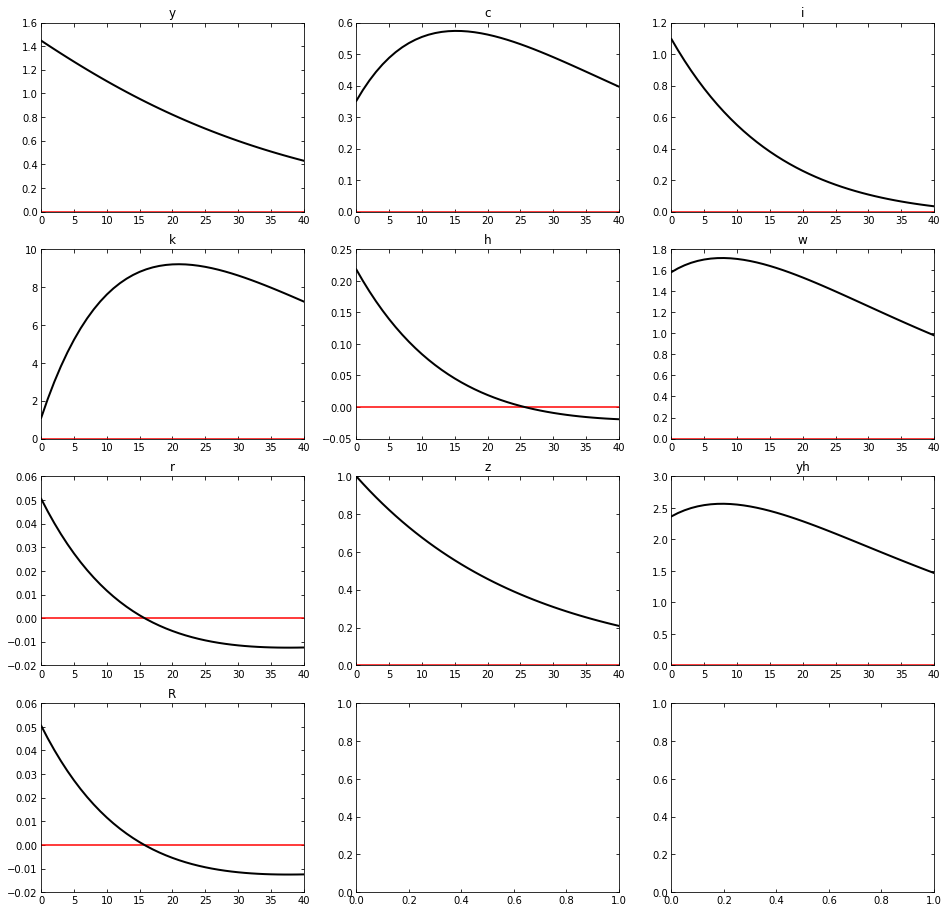

In [34]:
rbc.steady()

rbc.stoch_simul(irf=40)

In [35]:
rbc.SimulatedMoments(hp_filter=1600, shocks_stderr=stderr_z)
# rbc.SimulatedMoments(hp_filter=1600, shocks_stderr=0.007798087388691292)

SIMULATED MOMENTS

VARIABLE 	 STD. DEV.
y 		 1.4665
c 		 0.5232
i 		 4.7772
k 		 0.4200
h 		 0.6647
w 		 0.8213
r 		 5.2232
z 		 1.0126
yh 		 0.8213
R 		 0.0514

COEFFICIENTS OF AUTOCORRELATION
y 		 0.7209
c 		 0.7960
i 		 0.7099
k 		 0.9599
h 		 0.7074
w 		 0.7455
r 		 0.7087
z 		 0.7159
yh 		 0.7455
R 		 0.7079

MATRIX OF CORRELATIONS
Variables 	 y
y 		 1.0000
c 		 0.9218
i 		 0.9883
k 		 0.3620
h 		 0.9784
w 		 0.9863
r 		 0.9534
z 		 0.9987
yh 		 0.9863
R 		 0.9586


In [45]:
print('Standard Deviations')
print(hp_cycles.std())

print('')
print('Autocorrelations')
a = list(dta.columns.values[:10])
for i in range(len(a)):
    print(dta.columns.values[i], '  \t\t', hp_cycles[dta.columns.values[i]].autocorr())

print('')
print('Correlations')
print(hp_cycles.corr(method='pearson'))

Standard Deviations
Output           1.583536
Consumption      0.837034
Investment       4.480931
Capital          0.561865
Hours            1.595287
Wages            0.823227
Interest Rate    0.386774
TFP              0.984396
Productivity     1.289771
Price Level      0.889009
dtype: float64

Autocorrelations
Output   		 0.8489181324126912
Consumption   		 0.8251642253383615
Investment   		 0.867930160662462
Capital   		 0.9664826982785112
Hours   		 0.9010201175013728
Wages   		 0.6759196832087512
Interest Rate   		 0.41049766770604296
TFP   		 0.699575760211809
Productivity   		 0.6404053281716215
Price Level   		 0.9096604004397023

Correlations
                 Output  Consumption  Investment   Capital     Hours  \
Output         1.000000     0.749030    0.790164  0.366295  0.809091   
Consumption    0.749030     1.000000    0.636950  0.395370  0.676125   
Investment     0.790164     0.636950    1.000000  0.245121  0.638790   
Capital        0.366295     0.395370    0.245121  1.0